In [1]:
import xarray as xr
import sys
sys.path.append("/Users/ccamargo/Documents/py_scripts/")
import utils_SL as sl 
import utils_hec as hec
import numpy as np
import pandas as pd
import os
import seaborn as sns


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
cmap = cmocean.cm.balance
import matplotlib.pyplot as plt

def plot_map( data,
             lon=np.arange(0,360),lat=np.arange(-90,90),
             cmap='tab10',
             cmin=0,cmax=9,
             fsize=(15,10),
             proj='robin',
             land=True,
             grid=True,
             title='',
             clabel='',
             lon0=0,
             landcolor='papayawhip',
             extent = False
             ) :
    
   

    plt.figure(figsize=(15,10),dpi=100)
    if proj=='robin':
        proj=ccrs.Robinson(central_longitude=lon0)
    else:
        proj=ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj
                     #Mercator()
                     )
    #ax.background_img(name='pop', resolution='high')
    if extent:    
        ax.set_extent(extent,ccrs.PlateCarree())
    else:
        ax.set_global()
    ##             min_lon,,max_lon,minlat,maxlat
    mm = ax.pcolormesh(lon,\
                       lat,\
                       data,
                       vmin=cmin, vmax=cmax, 
                       transform=ccrs.PlateCarree(),
                       #cmap='Spectral_r'
                       cmap=cmap
                      )
    if land:
        
        
        # ax.add_feature(cfeature.LAND, facecolor=landcolor)
      
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='gray', facecolor=landcolor))
       
        # resol = '50m'  # use data at this scale
       
        # land = cfeature.NaturalEarthFeature('physical', 'land', scale=resol, edgecolor='k', facecolor=cfeature.COLORS['land'])
        # ax.add_feature(land, facecolor='beige')

        
    # d01 box
    if grid:
        gl=ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        # gl.xformatter = LONGITUDE_FORMATTER
        # gl.yformatter = LATITUDE_FORMATTER
    plt.colorbar(mm,label=clabel,orientation='horizontal',
                     shrink=0.9)
    plt.title(title,fontsize=20)

#    plt.show()
    # plt.close()    
    return

In [3]:
def plot_map_contour( data, contour,
             lon=np.arange(0,360),lat=np.arange(-90,90),
             cmap='tab10',
             cmin=0,cmax=9,
             fsize=(15,10),
             proj='robin',
             land=True,
             grid=True,
             title='',
             clabel='',
             lon0=0,
             landcolor='papayawhip',
             contourcolor='black',
             extent = False
             ) :
    
   

    plt.figure(figsize=(15,10),dpi=100)
    if proj=='robin':
        proj=ccrs.Robinson(central_longitude=lon0)
    else:
        proj=ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj
                     #Mercator()
                     )
    #ax.background_img(name='pop', resolution='high')
    if extent:    
        ax.set_extent(extent,ccrs.PlateCarree())
    else:
        ax.set_global()
    ##             min_lon,,max_lon,minlat,maxlat
    mm = ax.pcolormesh(lon,\
                       lat,\
                       data,
                       vmin=cmin, vmax=cmax, 
                       transform=ccrs.PlateCarree(),
                       #cmap='Spectral_r'
                       cmap=cmap
                      )
    plt.contour(lon,lat,contour,colors=contourcolor,levels=np.arange(1,np.nanmax(contour)+1,1),linewidths=0.25,zorder=1,
                transform=ccrs.PlateCarree()
               )

    if land:
        
        # ax.add_feature(cfeature.LAND, facecolor=landcolor)
      
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=landcolor, facecolor=landcolor))
       
        # resol = '50m'  # use data at this scale
       
        # land = cfeature.NaturalEarthFeature('physical', 'land', scale=resol, edgecolor='k', facecolor=cfeature.COLORS['land'])
        # ax.add_feature(land, facecolor='beige')

        
    # d01 box
    if grid:
        gl=ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        # gl.xformatter = LONGITUDE_FORMATTER
        # gl.yformatter = LATITUDE_FORMATTER
    plt.colorbar(mm,label=clabel,orientation='horizontal',
                     shrink=0.9)
    plt.title(title,fontsize=20)

#    plt.show()
    # plt.close()    
    return

In [4]:
def cluster_mean(data,mask,
                 time=[0],
                 lat=[0],
                 lon=[0],
                 norm=True,
                 stats='mean'):
    ''' 
    Function to compute mean, min max time series of a dataset, given a mask
    If norm=True, then data is normalized by range before computing mean,min,max
    returns a time series which has mean on axis 0, min on axis 1 and max on axis 2
    '''
    dims=data.shape
    if len(lat)!=dims[1]:
        lat = np.arange(0,dims[1])
    if len(lon)!=dims[2]:
        lon=np.arange(0,dims[2])
    if len(time)!=dims[0]:
        time = np.arange(0,dims[0])
    da = xr.Dataset(data_vars={'data':(('time','lat','lon'),data*mask),                          
                           },
                coords={'lat':lat,
                        'lon':lon,
                        'time':time,
                        }
                )
    if norm:
        da['data']=da.data - da.data.mean()
    if stats =='all':
        time_series=np.zeros((3,dims[0]))
        time_series[0,:] = da.data.mean(dim=('lat','lon')).data 
        time_series[1,:] = da.data.min(dim=('lat','lon')).data
        time_series[2,:] = da.data.max(dim=('lat','lon')).data
    elif stats=='mean':
        time_series = da.data.mean(dim=('lat','lon')).data 

    
    return time_series

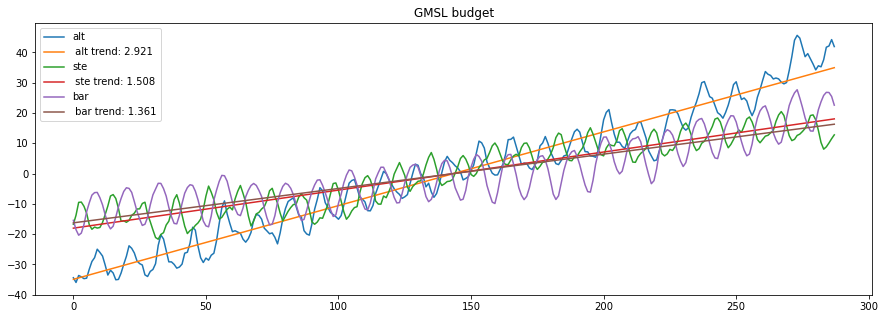

In [5]:
#%% budget componenets file
path = '/Users/ccamargo/Desktop/budget/data/'
file = 'SLA_alt+comps_1993-2016_trends.nc'

da=xr.open_dataset(path+file)
gmsl = np.array(da.sla.mean(dim=('lat','lon')))

tdec, _ = sl.get_dec_time(da.time)
plt.figure(figsize=(15,5))
var=np.array(da.contribution)

for i in range(len(var)):
    y = np.array(gmsl[:,i] - np.nanmean(gmsl[:,i]))
    trend, error, acc,trend_with_error,std_trend = sl.get_OLS_trend(tdec,y)
    name=np.array(var[i])
    plt.plot(y,label='{}'.format(name))
    out=sl.get_ts_trend(tdec,y,plot=False)
    plt.plot(out[1],label=' {} trend: {}'.format(name,np.round(out[0],3)))
plt.legend()
plt.title('GMSL budget')
plt.show()

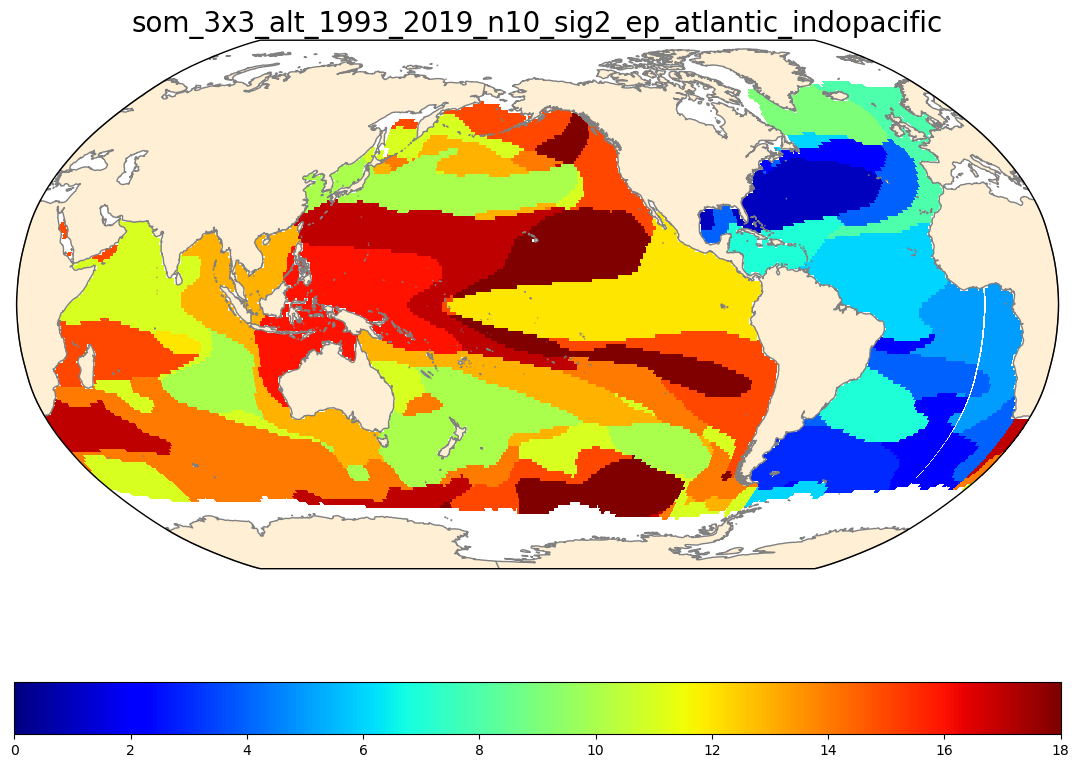

In [7]:
# som clusters
path = '/Users/ccamargo/Desktop/budget/regions/som/'
flist=['som_3x3_alt_1993_2019_n10_sig2_ep_atlantic.nc', 'som_3x3_alt_1993_2019_n10_sig2_ep_indopacific.nc']

mask=np.zeros((180,360))
ds=xr.open_dataset(path+flist[0])
ds.bmu_map.max()
n_neurons = len(ds.neurons)
mask=np.array(ds.bmu_map)
mask[np.isnan(mask)]=0
ds=xr.open_dataset(path+flist[1])
mask2=np.array(ds.bmu_map + n_neurons)
mask2[np.isnan(mask2)]=0
mask=np.array(mask+mask2)
mask[np.where(mask==0)]=np.nan

title = 'som_3x3_alt_1993_2019_n10_sig2_ep_atlantic_indopacific'
plot_map(mask,lon0=205,fsize=(15,10),cmap='jet',title=title,cmax=18,grid=False)


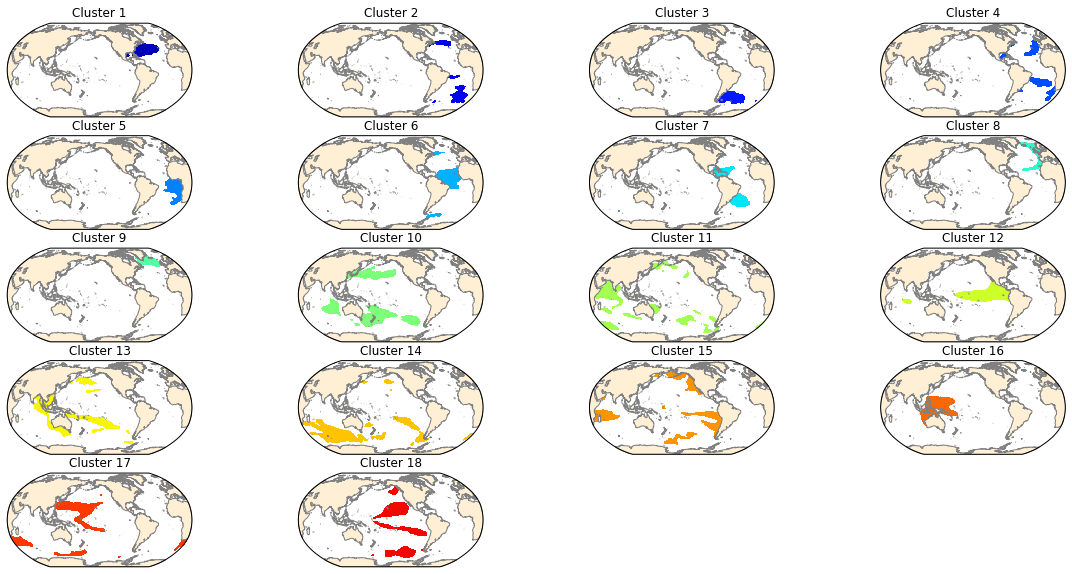

In [8]:

mask_comb = np.array(mask)
x=4
y=5
plt.figure(figsize=(20,10))
for i in range(0,int(np.nanmax(mask_comb))):
    icluster = i+1
    ax = plt.subplot(y,x,icluster, projection = ccrs.Robinson(central_longitude=210))
    ax.set_global()
    mask=np.array(mask_comb)
    mask[np.where(mask!=icluster)]=np.nan
    mm = ax.pcolormesh(ds.lon,\
                       ds.lat,\
                       mask,
                       vmin=0, vmax=x*y, 
                       transform=ccrs.PlateCarree(),
                       #cmap='Spectral_r'
                       cmap='jet'
                      )
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                                edgecolor='gray', facecolor='papayawhip'))
    plt.title('Cluster {}'.format(icluster))

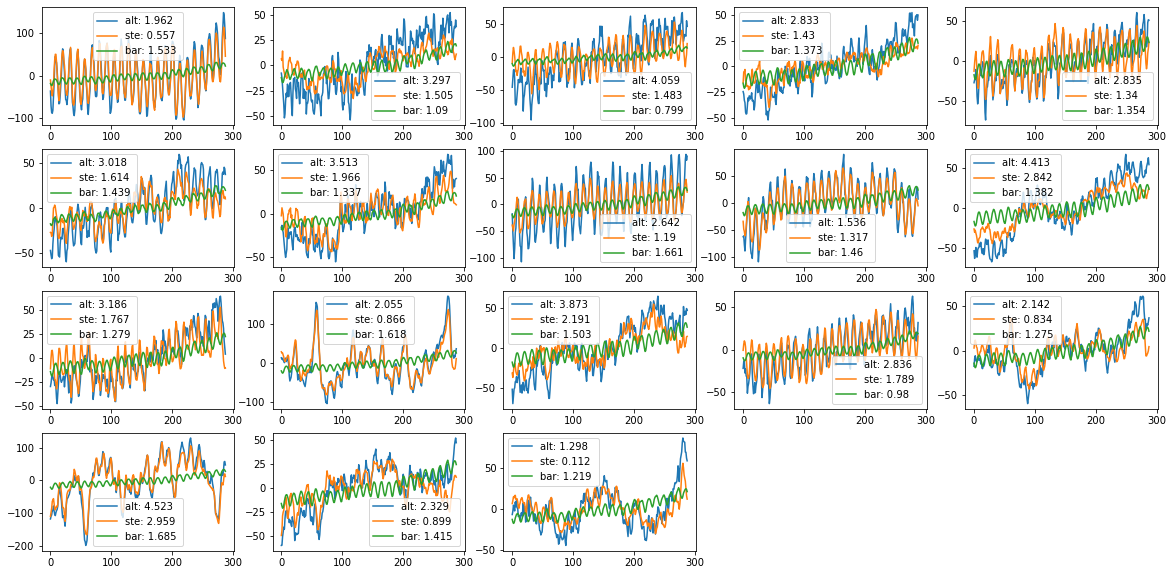

In [9]:

# get time series in each cluster
n_cluster=np.unique(mask_comb[np.isfinite(mask_comb)])
n_cluster

ts=np.zeros((len(n_cluster),len(var),len(da.time)))
tr=np.zeros((len(n_cluster),len(var)))
plt.figure(figsize=(20,10))
budget_cluster=np.full_like(mask,np.nan)
budget_res = np.full_like(mask,np.nan)
budget_noise = np.full_like(mask,np.nan)
y=4
x=5

for i in range(len(n_cluster)):
    icluster = i+1
    mask=np.array(mask_comb)
    mask[np.where(mask!=icluster)]=np.nan
    mask[np.isfinite(mask)]=1
    # plt.pcolor(mask)
    # plt.show()
    ampl = np.abs(np.nanmax(da.sla[:,:,:,0]*mask) - np.nanmin(da.sla[:,:,:,0]*mask))
    plt.subplot(y,x,icluster)
    # plt.subplot(111)
    for ivar in range(len(var)):
        ts[i,ivar,:] = cluster_mean(np.array(da.sla[:,:,:,ivar]), mask,time=da.time,lat=da.lat,lon=da.lon)
        out = sl.get_OLS_trend(tdec,ts[i,ivar])
        tr[i,ivar]=out[0]
        plt.plot(ts[i,ivar,:],label='{}: {} '.format(var[ivar],np.round(tr[i,ivar],3)))
    plt.legend()


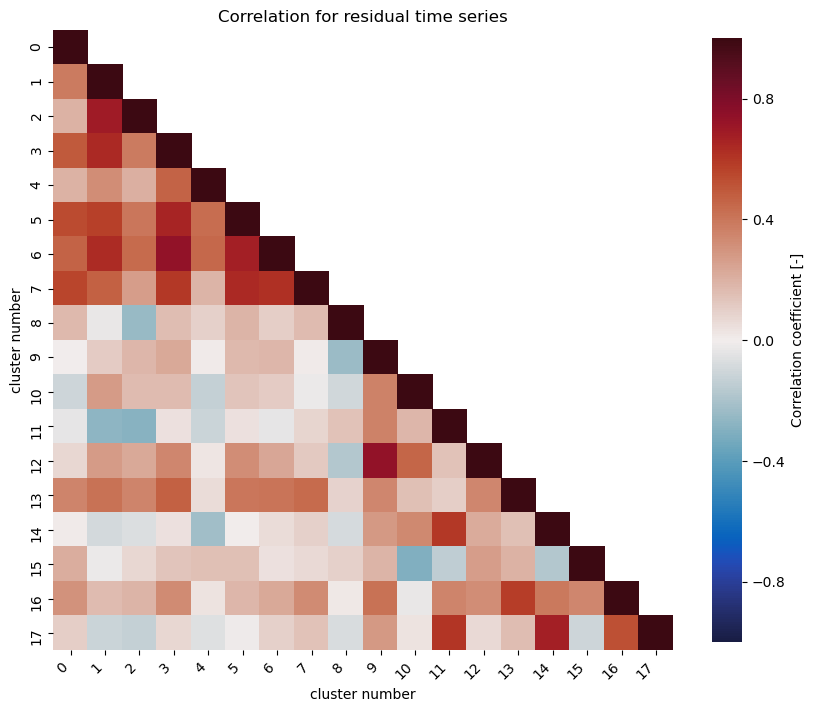

In [10]:
#%% residual time series in each cluster
ts_res = np.array(ts[:,0,:] - (ts[:,1,:]+ts[:,2,:]))
ts_res.shape

#%% correlation of the residual time series in each cluster
df=pd.DataFrame(ts_res.T)
# print(df.head())
cor=df.corr()
# print(cor.head())

# Generate a mask for the upper triangle
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.array(cor)==1]=False # plot middle squares as well
fig=plt.figure(figsize=(10,10),dpi=100)
ax = sns.heatmap(
    cor, 
    mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap=cmocean.cm.balance, # replace with Brodie's?,
    square=True,
    annot=False,
    cbar=1,
    cbar_kws={'label': 'Correlation coefficient [-]','shrink':.8},
#    xticklabels=lb,
#    yticklabels=lb,
    fmt='2.2f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.title('Correlation for residual time series')
plt.ylabel('cluster number')
plt.xlabel('cluster number')
plt.show()

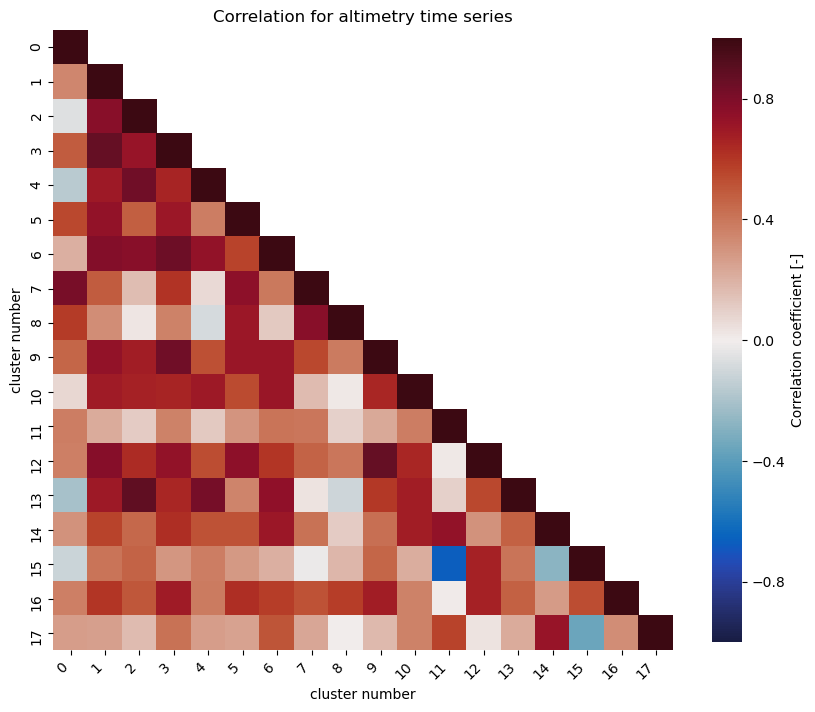

In [11]:
# correlation of the altimetry time series in each cluster
df=pd.DataFrame(ts[:,0,:].T)
#print(df.head())
cor=df.corr()
#print(cor.head())

# Generate a mask for the upper triangle
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.array(cor)==1]=False
fig=plt.figure(figsize=(10,10),dpi=100)
ax = sns.heatmap(
    cor, 
    mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap=cmocean.cm.balance, # replace with Brodie's?,
    square=True,
    annot=False,
    cbar=1,
    cbar_kws={'label': 'Correlation coefficient [-]','shrink':.8},
#    xticklabels=lb,
#    yticklabels=lb,
    fmt='2.2f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.title('Correlation for altimetry time series')
plt.ylabel('cluster number')
plt.xlabel('cluster number')
plt.show()

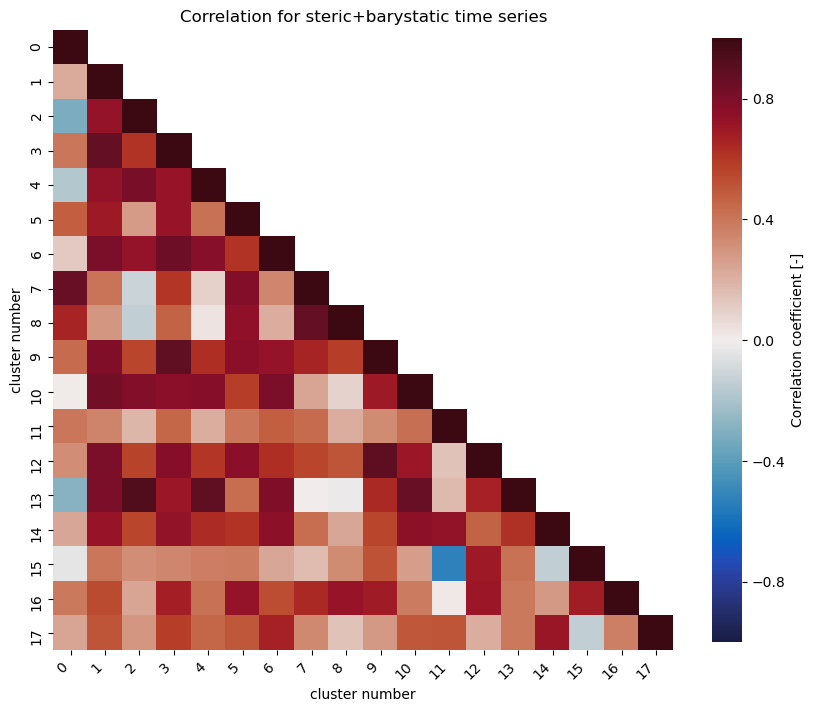

In [12]:




# correlation of the steric+barys time series in each cluster
df=pd.DataFrame(np.array(ts[:,1,:]+ts[:,2,:]).T)
#print(df.head())
cor=df.corr()
#print(cor.head())

# Generate a mask for the upper triangle
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.array(cor)==1]=False
fig=plt.figure(figsize=(10,10),dpi=100)
ax = sns.heatmap(
    cor, 
    mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap=cmocean.cm.balance, # replace with Brodie's?,
    square=True,
    annot=False,
    cbar=1,
    cbar_kws={'label': 'Correlation coefficient [-]','shrink':.8},
#    xticklabels=lb,
#    yticklabels=lb,
    fmt='2.2f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.title('Correlation for steric+barystatic time series')
plt.ylabel('cluster number')
plt.xlabel('cluster number')
plt.show()

In [13]:
budget_res= np.array(tr[:,0] - (tr[:,1]+tr[:,2]))

plt.figure(figsize=(20,10))
budget_res_map=np.full_like(mask_comb,np.nan)

y=4
x=5

for i in range(len(n_cluster)):
    icluster = i+1
    mask=np.array(mask_comb)
    mask[np.where(mask!=icluster)]=np.nan
    mask[np.isfinite(mask)]=1
    # plt.pcolor(mask)
    # plt.show()
    budget_res_map[np.where(mask==1)] = budget_res[i]



<Figure size 1440x720 with 0 Axes>

/Users/ccamargo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


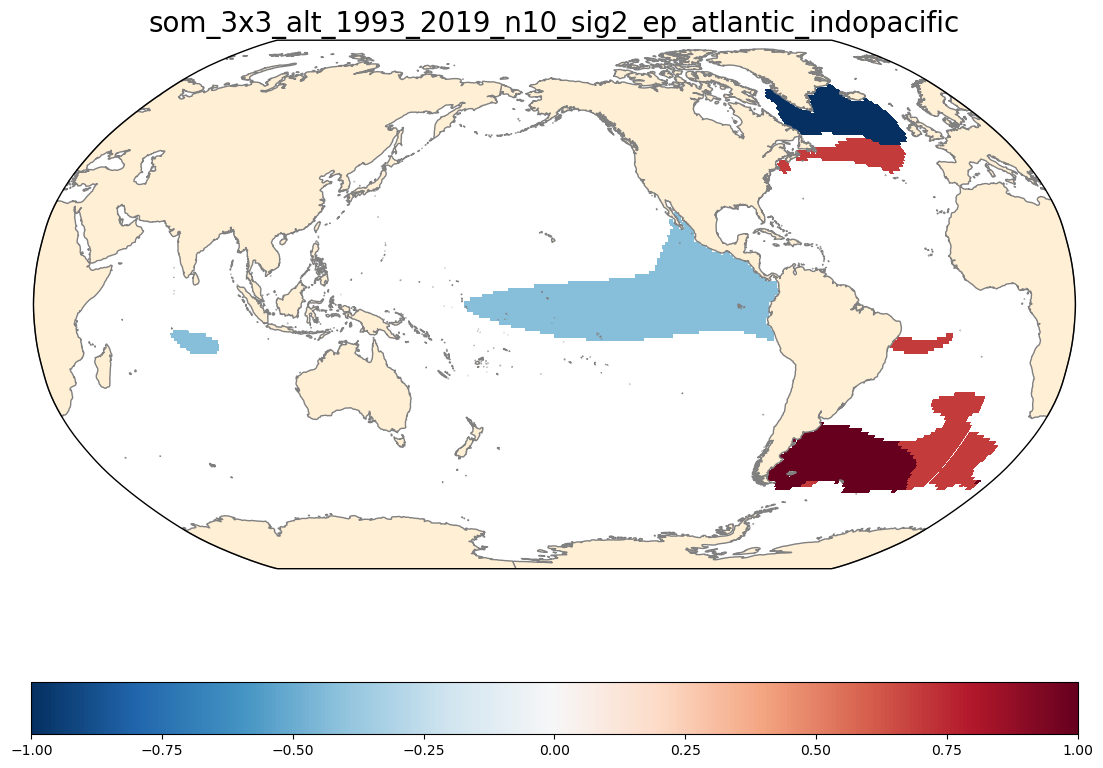

In [19]:
budget_res_map_sig=np.array(budget_res_map)
budget_res_map_sig[np.abs(budget_res_map_sig)<0.3]=np.nan
plot_map(budget_res_map_sig,lon0=205,fsize=(15,10),cmap='RdBu_r',
         title=title,cmax=1,cmin=-1,grid=False)


In [26]:
budget_res

array([-0.12851073,  0.7010501 ,  1.77822837,  0.03028127,  0.14115097,
       -0.03468473,  0.20978743, -0.20883701, -1.24071229,  0.18874217,
        0.13976488, -0.42787942,  0.1794407 ,  0.06676304,  0.03325581,
       -0.122081  ,  0.01410636, -0.03333614])

In [23]:
dimlat=180;dimlon=360

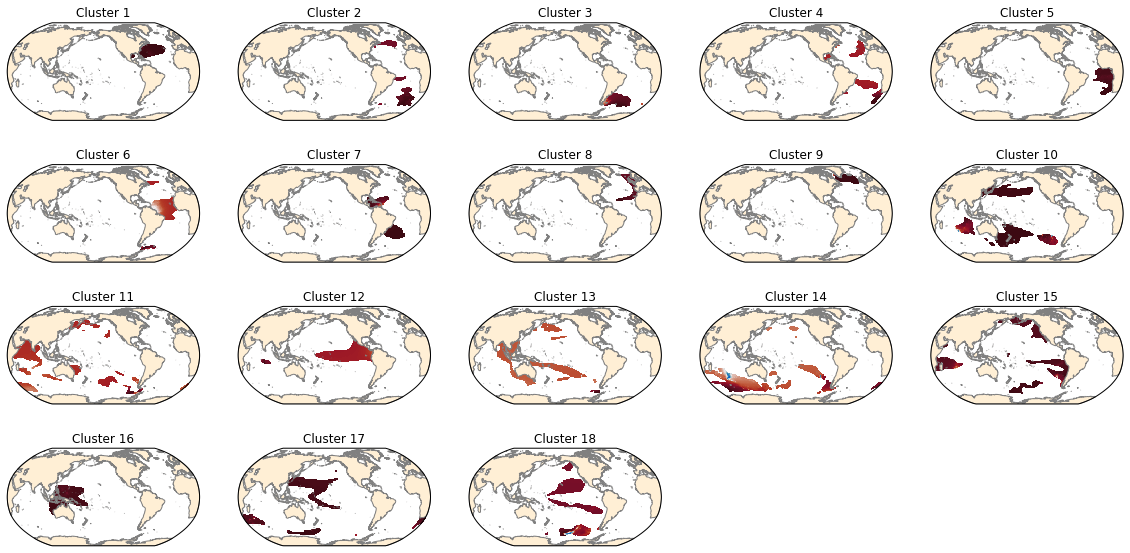

In [24]:
cor_map = np.zeros((dimlat,dimlon))
dimtime,dimlat,dimlon=np.array(da.sla[:,:,:,ivar]).shape

y=4
x=5
#%% plot each cluster
plt.figure(figsize=(20,10))
    
for i in range(len(n_cluster)):
    icluster = i+1
    mask=np.array(mask_comb)
    mask[np.where(mask!=icluster)]=np.nan
    mask[np.isfinite(mask)]=1
    
    data=np.array(da.sla[:,:,:,ivar]*mask)
    dimcoord = data[np.isfinite(data)].shape[0]
    masknew=np.array(data[0,:,:]*mask)
    masknew[np.isfinite(masknew)]=1
    data=data[np.isfinite(data)].reshape(dimtime,int(dimcoord/dimtime))
    
    yref=np.array(data[:,10])
    cors = np.zeros((data.shape[1]))
    for i in range(len(cors)):
        cors[i]=np.corrcoef(yref,np.array(data[:,i]))[0,1]
    cor_map[np.isfinite(masknew)]=cors
    mask_tmp=np.full_like(cor_map,np.nan)
    mask_tmp[np.isfinite(masknew)]=cors
    
    ax = plt.subplot(y,x,icluster, projection = ccrs.Robinson(central_longitude=210))
    ax.set_global()
    mm = ax.pcolormesh(ds.lon,\
                       ds.lat,\
                       mask_tmp,
                       vmin=-1, vmax=1, 
                       transform=ccrs.PlateCarree(),
                       #cmap='Spectral_r'
                       cmap=cmocean.cm.balance
                      )
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                                edgecolor='gray', facecolor='papayawhip'))
    plt.title('Cluster {}'.format(icluster))
plt.show()

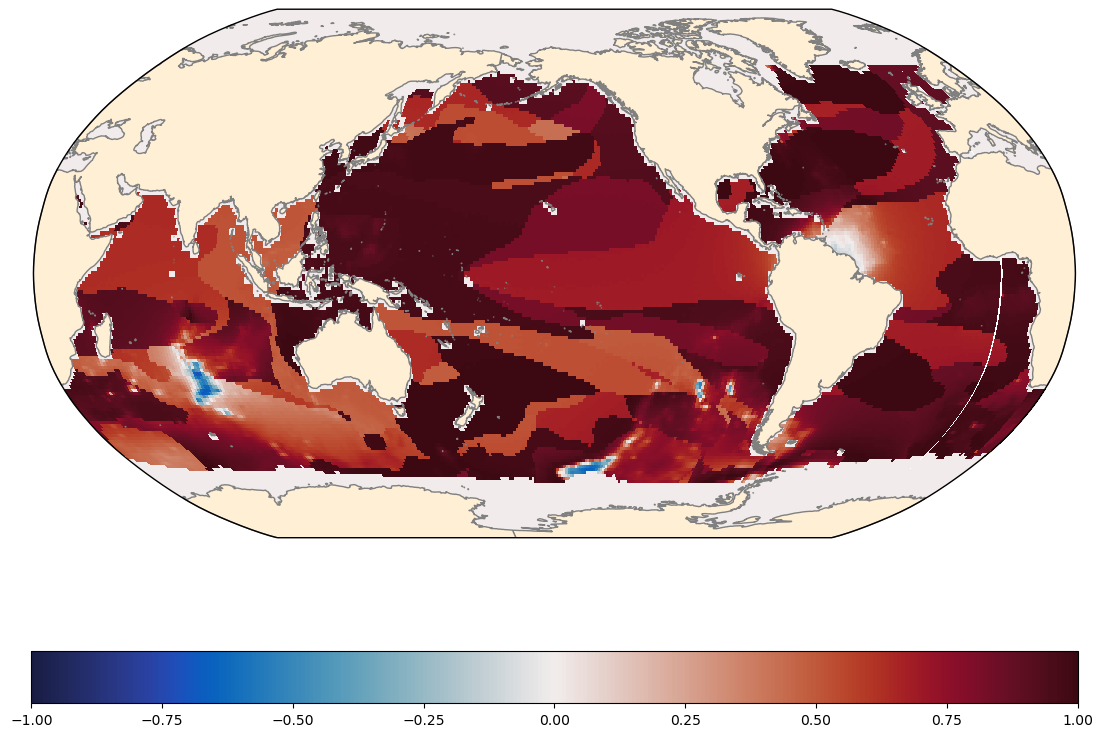

In [26]:
plot_map(cor_map,cmap=cmocean.cm.balance,cmin=-1,cmax=1,lon0=205,grid=False)

In [27]:
contour=np.array(mask_comb)
contour[np.isnan(contour)]=0
    

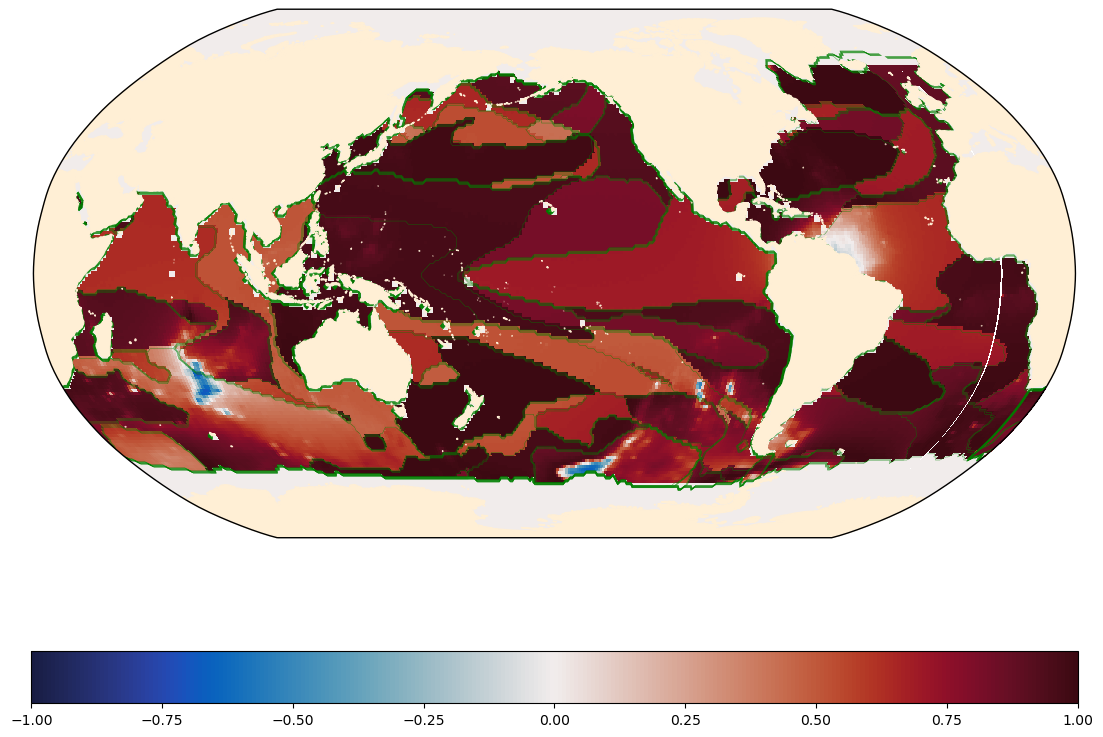

In [28]:
plot_map_contour(cor_map,contour,lon0=205,fsize=(15,10),cmap=cmocean.cm.balance,cmin=-1,cmax=1,
                 grid=False,
                contourcolor='green')
#         title='Residual Budget at each cluster',cmax=clim,cmin=-clim,clabel='mm/yr')